# Running component models

There are many component models in Source, such as rainfall runoff models and routing models. Many of these can be run independently, outside of the context of a Source scenario.

There are various ways to do this from Python, some which use Veneer and some that don't.

This example notebook demonstrates how it can be done through Veneer.

In [1]:
import veneer
from veneer.manage import start, kill_all_now

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Start a copy of the Veneer command line, *without* a Source project file

Recent versions of Veneer include the option to start the command line without specifying a Source project.

In this case, the Veneer command line starts, and creates a new Source Project and Source Scenario 'in memory'. This option can be used to create a scenario (node, links, etc) entirely from Python. Alternatively (and in this example) we can simply ignore the newly created project and scenario and run individual models through Veneer

In [2]:
PATH_TO_VENEER='<path to FlowMatters.Source.VeneerCmd.exe, likely set up by veneer.manage.create_command_line>'

In [4]:
processes,ports = start(veneer_exe=PATH_TO_VENEER,debug=True,project_fn=None)


Starting D:\src\projects\py\veneer-py\doc\examples\simulation\veneer_cmd\FlowMatters.Source.VeneerCmd.exe -p 9876 -r -s  
[0] Loading plugins

[0] Loaded D:\src\projects\gbr\Output\Plugins\CommunityPlugins\GBR_DynSed_Extension.dll

[0] Loaded D:\src\projects\gbr\Output\Plugins\CommunityPlugins\ReefHydroCalModels.dll

[0] Plugins loaded (2/5)

[0] Scenario 1

[0] [2:39:38 PM] Veneer, by Flow Matters: http://www.flowmatters.com.au

[0] [2:39:38 PM] Started Source RESTful Service on port:9877

Server 0 on port 9876 is ready
[0] Server started. Ctrl-C to exit, or POST /shutdown command



## Model setup

We will run the Simhyd rainfall runoff model. Simhyd requires rainfall and PET and the Source version of Simhyd has 9 parameters.

We need to know:

* The name of the model class in Source,
* The names of the inputs - where we will use timeseries,
* The names of the parameters and their default values, which we might change
* The names of any state variables and outputs, which we might choose to record as time series

These are discoverable through the Veneer interface

In [5]:
v = veneer.Veneer(ports[0])

In [6]:
model_name = v.model.find_model_type('SimHydCs')[0]
model_name

'TIME.Models.RainfallRunoff.SimHyd.SimHydCs'

In [7]:
v.model.find_inputs(model_name)

['pet', 'rainfall']

In [8]:
v.model.find_outputs(model_name)

['MassBalance', 'runoff']

In [9]:
v.model.find_states(model_name)

['EffectiveRainfall',
 'EventRunoff',
 'Groundwater',
 'ImperviousEt',
 'ImperviousIncident',
 'ImperviousRunoff',
 'Infiltration',
 'InfiltrationAfterFlow',
 'InfiltrationAfterInterflow',
 'InfiltrationCapacity',
 'InfiltrationXsRunoff',
 'InterceptionEt',
 'InterflowRunoff',
 'PerviousIncident',
 'Recharge',
 'SoilEt',
 'SoilInput',
 'SoilMoistureStore',
 'Throughfall',
 'TotalEt',
 'TotalStore',
 'baseflow']

In [10]:
DEFAULT_PARAMETERS = v.model.find_default_parameters(model_name)
DEFAULT_PARAMETERS

{'baseflowCoefficient': 0.3,
 'imperviousThreshold': 1,
 'infiltrationCoefficient': 200,
 'infiltrationShape': 3,
 'interflowCoefficient': 0.1,
 'perviousFraction': 0.9,
 'rainfallInterceptionStoreCapacity': 1.5,
 'rechargeCoefficient': 0.2,
 'soilMoistureStoreCapacity': 320}

## Setup input time series

Each input time series needs to be a pandas Series object, with a datetime index.



In [11]:
tbl = pd.read_csv('eg_climate.csv',index_col='date',parse_dates=True)
tbl[:10]

,rain,evap
date,,
1995-01-01,0.0,18.0
1995-01-02,0.0,17.0
1995-01-03,0.0,14.0
1995-01-04,0.1,12.4
1995-01-05,1.0,14.0
1995-01-06,0.0,17.2
1995-01-07,0.0,16.8
1995-01-08,0.0,15.6
1995-01-09,0.0,15.0


In [12]:
tbl.index

DatetimeIndex(['1995-01-01', '1995-01-02', '1995-01-03', '1995-01-04',
               '1995-01-05', '1995-01-06', '1995-01-07', '1995-01-08',
               '1995-01-09', '1995-01-10',
               ...
               '2005-12-22', '2005-12-23', '2005-12-24', '2005-12-25',
               '2005-12-26', '2005-12-27', '2005-12-28', '2005-12-29',
               '2005-12-30', '2005-12-31'],
              dtype='datetime64[ns]', name='date', length=4018, freq=None)

In [13]:
inputs = {
    'rainfall':tbl['rain'],
    'pet':tbl['evap']
}

## Run the model

In [14]:
things_to_record = [
    'runoff',
    'baseflow',
    'SoilMoistureStore',
    'Groundwater'
]

In [15]:
res = v.model.component.run_model(model_name,
                                  inputs=inputs,
                                  parameters=DEFAULT_PARAMETERS,
                                  outputs=things_to_record)

In [16]:
res[:10]

,Groundwater,SoilMoistureStore,baseflow,runoff
1995-01-01,0.0,0.0,0.0,0.0
1995-01-02,0.0,0.0,0.0,0.0
1995-01-03,0.0,0.0,0.0,0.0
1995-01-04,0.0,0.0,0.0,0.0
1995-01-05,0.0,0.0,0.0,0.0
1995-01-06,0.0,0.0,0.0,0.0
1995-01-07,0.0,0.0,0.0,0.0
1995-01-08,0.0,0.0,0.0,0.0
1995-01-09,0.0,0.0,0.0,0.0
1995-01-10,0.0,0.0,0.0,0.0


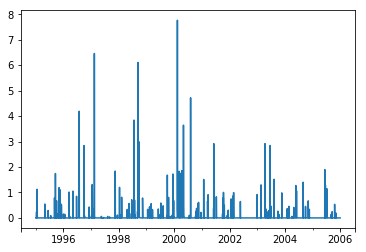

In [17]:
res['runoff'].plot()

## Shut down Veneer

In [18]:
kill_all_now(processes)